In [151]:
import tensorflow as tf
import os

In [152]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3654501368045228359
xla_global_id: -1
]


In [153]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices()
#for gpu in gpus: 
#   tf.config.experimental.set_memory_growth(gpu, True)

In [154]:
gpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [155]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [156]:
import cv2
import imghdr

In [157]:
data_dir = './data' 

In [158]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [159]:
os.listdir(data_dir)

['15', '25', '35', '45']

In [160]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [232]:
import numpy as np
from matplotlib import pyplot as plt

In [233]:
data = tf.keras.utils.image_dataset_from_directory('data',batch_size=4)

Found 19 files belonging to 4 classes.


In [234]:
data_iterator = data.as_numpy_iterator()

In [235]:
batch = data_iterator.next()

In [236]:
batch[1]

array([1, 2, 0, 0])

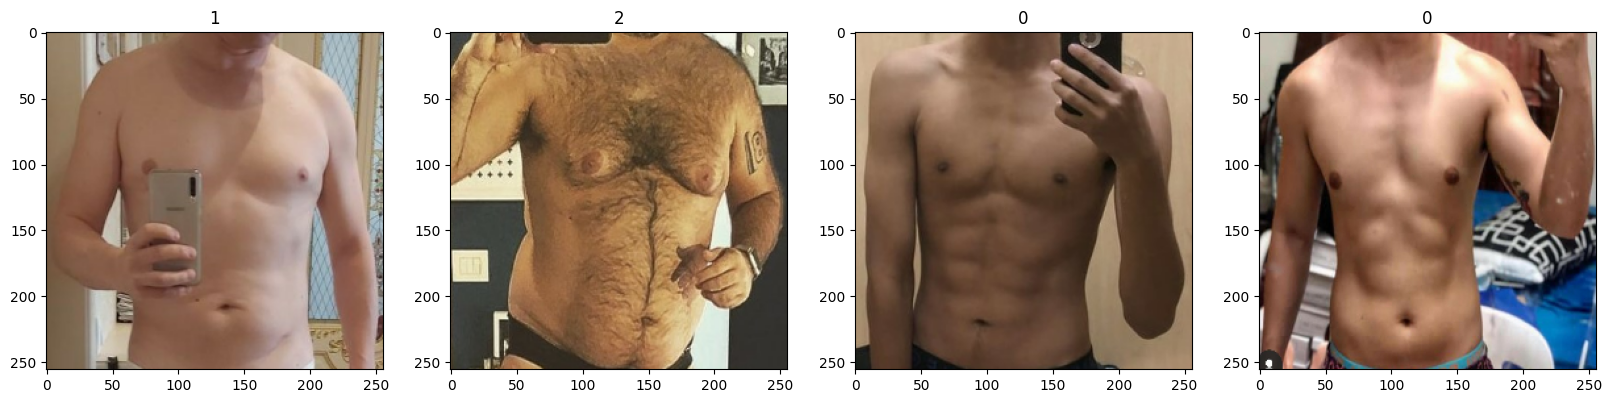

In [237]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [238]:
data = data.map(lambda x,y: (x/255, y))

In [239]:
data.as_numpy_iterator().next()

(array([[[[0.6392157 , 0.5137255 , 0.41568628],
          [0.6392157 , 0.5137255 , 0.41568628],
          [0.6392157 , 0.5137255 , 0.41568628],
          ...,
          [0.16078432, 0.09019608, 0.05098039],
          [0.15686275, 0.08627451, 0.04705882],
          [0.14901961, 0.07843138, 0.03921569]],
 
         [[0.6392157 , 0.5137255 , 0.41568628],
          [0.6392157 , 0.5137255 , 0.41568628],
          [0.6392157 , 0.5137255 , 0.41568628],
          ...,
          [0.16078432, 0.09019608, 0.05098039],
          [0.15686275, 0.08627451, 0.04705882],
          [0.14901961, 0.07843138, 0.03921569]],
 
         [[0.6392157 , 0.5137255 , 0.41568628],
          [0.6392157 , 0.5137255 , 0.41568628],
          [0.6392157 , 0.5137255 , 0.41568628],
          ...,
          [0.16078432, 0.09019608, 0.05098039],
          [0.15686275, 0.08627451, 0.04705882],
          [0.14901961, 0.07843138, 0.03921569]],
 
         ...,
 
         [[0.54818475, 0.4932828 , 0.48936123],
          [0.57821

In [240]:
all_labels = []

for _, y_batch in data:
    all_labels.extend(y_batch.numpy())  # Collect all labels from each batch

unique_labels = np.unique(all_labels)
print("Unique labels in the entire dataset:", unique_labels)

Unique labels in the entire dataset: [0 1 2 3]


# 5. Split Data

In [241]:
len(data)

5

In [242]:
train_size = int(len(data)*.7)
test_size = int(len(data)*.3)

In [243]:
test_size

1

In [244]:
train = data.take(train_size)
test = data.skip(train_size).take(test_size)

# 6. Build Deep Learning Model

In [245]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [246]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import keras

In [247]:
model = Sequential()

In [248]:
# Convolutional and pooling layers
model.add(Conv2D(16, (2, 2), strides=1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (2, 2), strides=1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D())

# Flatten and Dense layers for prediction
model.add(Flatten())
model.add(Dense(256, activation='relu'))  # Use ReLU for hidden layers
model.add(Dropout(0.3))  # Dropout for regularization
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# Output layer for regression (body fat percentage)
model.add(Dense(1, activation='linear'))  # Linear activation for regression

In [249]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [250]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 255, 255, 16)   │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 126, 126, 32)   │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,558,641 (25.02 MB)

 Trainable params: 6,558,641 (25.02 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [251]:
logdir='logs'

In [252]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [253]:
hist = model.fit(train, epochs=60, validation_data=test, callbacks=[tensorboard_callback])

Epoch 1/60


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - loss: 2.1973 - mae: 1.0951 - val_loss: 1.5125 - val_mae: 1.1228
Epoch 2/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - loss: 1.7166 - mae: 1.1780 - val_loss: 1.3787 - val_mae: 0.9046
Epoch 3/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - loss: 1.6428 - mae: 1.0540 - val_loss: 2.1503 - val_mae: 1.4378
Epoch 4/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - loss: 1.4840 - mae: 1.0678 - val_loss: 1.5816 - val_mae: 0.9966
Epoch 5/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - loss: 2.2768 - mae: 1.2126 - val_loss: 1.9047 - val_mae: 1.0743
Epoch 6/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - loss: 1.3463 - mae: 0.8916 - val_loss: 1.2436 - val_mae: 1.0022
Epoch 7/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - loss: 1.3773 - mae: 1.0847 - val_loss: 0.5620 - val_mae: 0.4783
Epoch 8/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - loss: 1.0331 - mae: 0.7770 - val_loss: 2.8941 - val_mae: 1.5379
Epoch 9/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - loss: 1.2472 - mae: 0.9210 - va

# 8. Plot Performance

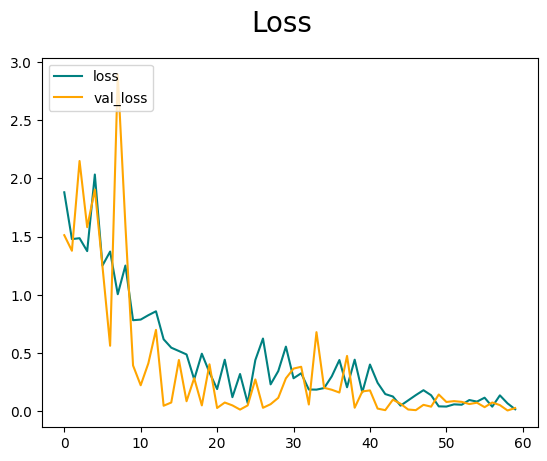

In [254]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

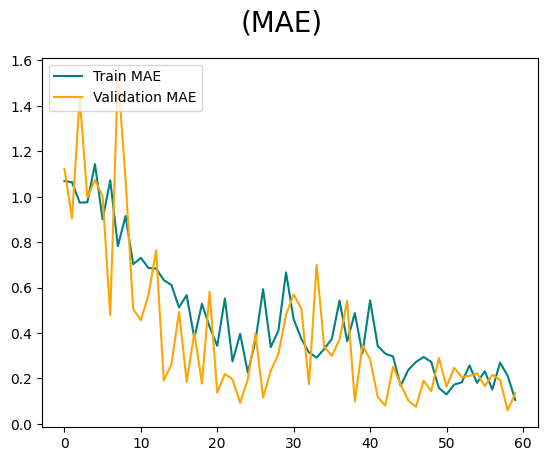

In [255]:
# Assuming you have the history object from the model training
fig = plt.figure()

# Plot training and validation MAE (mean absolute error) for regression
plt.plot(hist.history['mae'], color='teal', label='Train MAE')
plt.plot(hist.history['val_mae'], color='orange', label='Validation MAE')

# Title and labels
fig.suptitle('(MAE)', fontsize=20)  # You can also use 'Accuracy' or another metric name
plt.legend(loc="upper left")

# Show the plot
plt.show()

# 9. Evaluate

In [256]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [257]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [258]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


In [279]:
print(pre.result(), 
      re.result(), 
      acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.75, shape=(), dtype=float32)


# 10. Test

In [260]:
import cv2

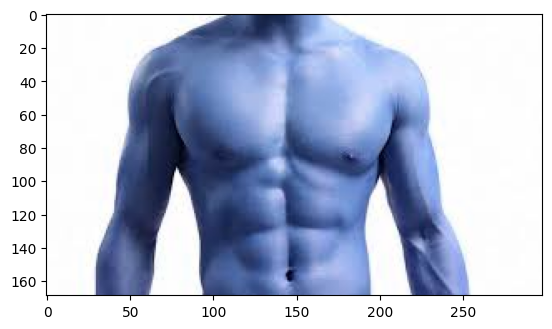

In [265]:
img = cv2.imread('images.jpeg')
plt.imshow(img)
plt.show()

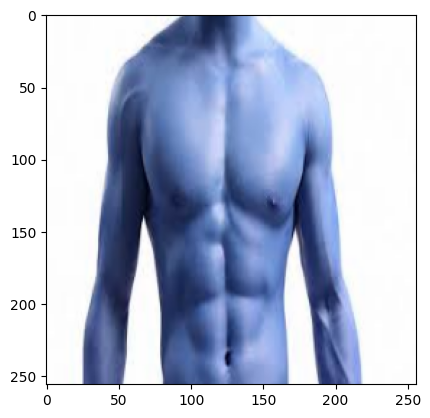

In [266]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

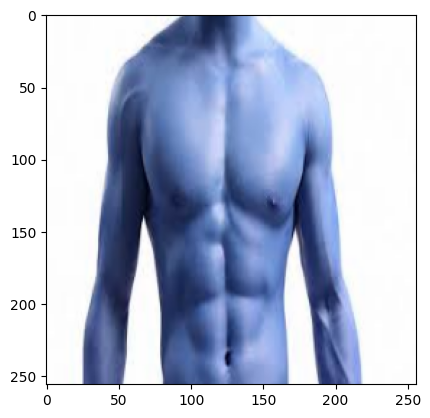

In [ ]:
resize_np = resize.numpy().astype(np.uint8)
plt.imshow(resize_np)
plt.show()

In [269]:
normalized_image = resize_np / 255.0
normalized_image = np.expand_dims(normalized_image, axis=0)

In [270]:
normalized_image.shape

(1, 256, 256, 3)

In [276]:
yhat = model.predict(normalized_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [277]:
def scale_output(predictions):
    # Scale predictions from [0, 3] to [10, 40]
    return predictions * 10 + 10

In [278]:
yhat = scale_output(yhat)
yhat

array([[15.17491]], dtype=float32)

# 11. Save the Model

In [199]:
from tensorflow.keras.models import load_model

In [200]:
model.save(os.path.join('models','bodyfatimageclassifier.h5'))